In [1]:
import jax
import jaxgboost

import optax

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, metrics

In [2]:
data = datasets.fetch_california_housing()
x = data['data']
y = data['target'].reshape(-1, 1)

n_train = 5_000
n_valid = 5_000
x_train, y_train = x[:n_train], y[:n_train]
x_valid, y_valid = x[n_train:n_train + n_valid], y[n_train:n_train + n_valid]
x_test,  y_test  = x[n_train + n_valid:], y[n_train + n_valid:]

ym = y_train.mean()
ys = y_train.std() + 1e-6

y_train = (y_train - ym) / ys
y_valid = (y_valid - ym) / ys
y_test  = (y_test  - ym) / ys

x_train = jax.numpy.array(x_train)
y_train = jax.numpy.array(y_train)

x_valid = jax.numpy.array(x_valid)
y_valid = jax.numpy.array(y_valid)

print(x_train.shape, x_valid.shape, x_test.shape)

(5000, 8) (5000, 8) (10640, 8)


In [3]:
static_params = {
    "n_estimators": 10,
    "max_depth": 4,
    "base_score": y_train.mean(),
    "jit": False
}


def train_and_eval(params, train_data, valid_data):
    xt, yt = train_data
    xv, yv = valid_data
    model = jaxgboost.JAXGBoostModel(**params, **static_params)
    model.fit(xt, yt)
    mse = jax.numpy.mean((yv - model.predict(xv)) ** 2)
    return mse


train_and_eval_jit = jax.jit(train_and_eval)
value_and_grad = jax.value_and_grad(train_and_eval)


@jax.jit
def train_loop(params, opt_state):
    STEPS_PER_LOOP = 1
    
    def step(i, state):
        _, params, opt_state = state

        value, grads = value_and_grad(params, (x_train, y_train), (x_valid, y_valid))
        
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)

        return value, params, opt_state

    value, params, opt_state = jax.lax.fori_loop(0, STEPS_PER_LOOP, step, (0.0, params, opt_state))
    return value, params, opt_state

In [4]:
params = {
    "learning_rate": 0.1,
    "max_delta_step": 0.1,
    "reg_alpha": 0.0,
    "reg_lambda": 1.0,
    "subsample": 1.0 # in the current implementation the gradient wrt "subsample" is always zero, so the value will not change
}

# the loss function is discontinuous, so keeping lr low is probably a good idea
optimizer = optax.adam(learning_rate=1e-3)
opt_state = optimizer.init(params)
mse_valid_history = []
mse_test_history  = []
params_history = []

for it in range(200):
    _, params, opt_state = train_loop(params, opt_state)
    mse_valid = train_and_eval_jit(params, (x_train, y_train), (x_valid, y_valid))
    mse_test  = train_and_eval_jit(params, (x_train, y_train), (x_test, y_test))
    mse_valid_history.append(mse_valid)
    mse_test_history.append(mse_test)
    params_history.append(params)

    params['learning_rate'] = jax.numpy.clip(params['learning_rate'], 0.0, 1.0)
    params['reg_lambda'] = jax.numpy.clip(params['reg_lambda'], 1e-6, 10.0)
    params['reg_alpha']  = jax.numpy.clip(params['reg_alpha'], 0.0, 10.0)

    if it % 10 == 0:
        print("%.4d\t%.4f\t%.4f" % (it, mse_valid, mse_test), {k: np.round(float(v), 6) for k, v in params.items()})

0000	0.8980	0.8493 {'learning_rate': 0.099, 'max_delta_step': 0.101, 'reg_alpha': 0.001, 'reg_lambda': 1.001, 'subsample': 1.0}
0010	0.8639	0.8397 {'learning_rate': 0.09934, 'max_delta_step': 0.110788, 'reg_alpha': 0.01075, 'reg_lambda': 1.010827, 'subsample': 1.0}
0020	0.8435	0.8187 {'learning_rate': 0.108007, 'max_delta_step': 0.120272, 'reg_alpha': 0.020639, 'reg_lambda': 1.020684, 'subsample': 1.0}
0030	0.7912	0.7812 {'learning_rate': 0.117444, 'max_delta_step': 0.12944, 'reg_alpha': 0.029496, 'reg_lambda': 1.029688, 'subsample': 1.0}
0040	0.7839	0.7700 {'learning_rate': 0.125479, 'max_delta_step': 0.13828, 'reg_alpha': 0.037688, 'reg_lambda': 1.038067, 'subsample': 1.0}
0050	0.7297	0.7432 {'learning_rate': 0.132504, 'max_delta_step': 0.146731, 'reg_alpha': 0.046225, 'reg_lambda': 1.046113, 'subsample': 1.0}
0060	0.6987	0.7508 {'learning_rate': 0.140404, 'max_delta_step': 0.154814, 'reg_alpha': 0.055853, 'reg_lambda': 1.054957, 'subsample': 1.0}
0070	0.7076	0.7553 {'learning_rate':

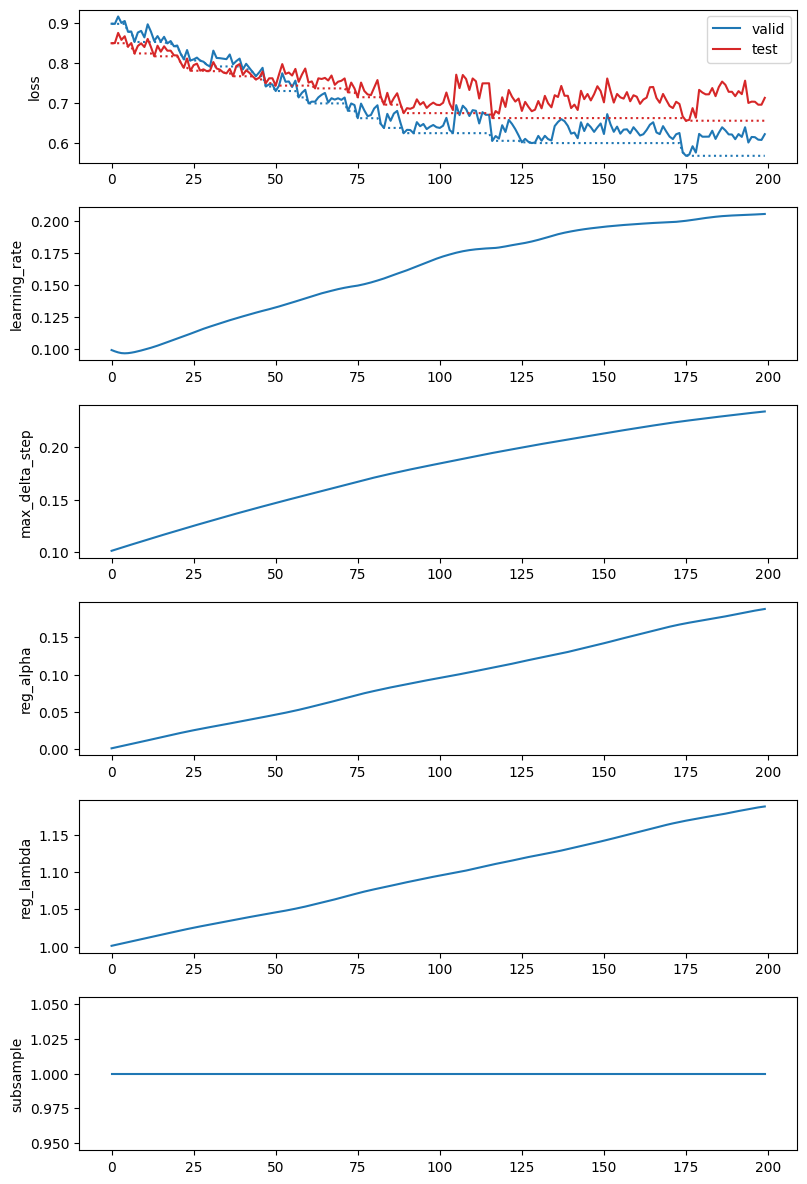

In [5]:
_, ax = plt.subplots(len(params.keys()) + 1, figsize=(8, 12))
plt.tight_layout()

ax[0].plot(mse_valid_history, color="tab:blue", label="valid")
ax[0].plot(jax.lax.cummin(jax.numpy.array(mse_valid_history)), color="tab:blue", linestyle=":")
ax[0].plot(mse_test_history, color="tab:red", label="test")
ax[0].plot(jax.lax.cummin(jax.numpy.array(mse_test_history)), color="tab:red", linestyle=":")
ax[0].legend()
ax[0].set_ylabel("loss")

for i, k in enumerate(params.keys()):
    ax[i + 1].plot([p[k] for p in params_history])
    ax[i + 1].set_ylabel(k)